In [1]:
import pyspark
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession

In [2]:
import findspark
findspark.init()

In [3]:
spark = SparkSession.builder \
.master("local") \
.config("spark.driver.extraClassPath","C:/Users/AnshumaanChauhan/Documents/spark-3.3.0-bin-hadoop3/spark-3.3.0-bin-hadoop3/jars/mysql-connector-java-5.1.48.jar") \
.config("spark.driver.memory","15g") \
.appName("Scalability Check of Systems for ML applications") \
.getOrCreate()

In [4]:
from pyspark.sql.functions import col, count, isnan, when

In [83]:
dataset = spark.read.csv('C:\\Users\AnshumaanChauhan\\Documents\\Systems for DS Umass\\Project\\archive (5)\\DelayedFlights.csv',
                         header=True)

In [67]:
#Checking which column has null or nan values how many times 
dataset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataset.columns]).show(vertical=True)

-RECORD 0-------------------
 _c0               | 0      
 Year              | 0      
 Month             | 0      
 DayofMonth        | 0      
 DayOfWeek         | 0      
 DepTime           | 0      
 CRSDepTime        | 0      
 ArrTime           | 7110   
 CRSArrTime        | 0      
 UniqueCarrier     | 0      
 FlightNum         | 0      
 TailNum           | 5      
 ActualElapsedTime | 8387   
 CRSElapsedTime    | 198    
 AirTime           | 8387   
 ArrDelay          | 8387   
 DepDelay          | 0      
 Origin            | 0      
 Dest              | 0      
 Distance          | 0      
 TaxiIn            | 7110   
 TaxiOut           | 455    
 Cancelled         | 0      
 CancellationCode  | 0      
 Diverted          | 0      
 CarrierDelay      | 689270 
 WeatherDelay      | 689270 
 NASDelay          | 689270 
 SecurityDelay     | 689270 
 LateAircraftDelay | 689270 



In [68]:
dataset.select(col("ArrDelay")).where((col("ArrDelay").isNull() | isnan(col("ArrDelay"))) & (col('Diverted')==1)).count()

7754

For all the flights that are diverted their ActualElaspedTime, ArrDelay and AirTime is null, because they did not land at correct destination

In [69]:
dataset.select(*(col(c) for c in dataset.columns)).where((col("TaxiIn").isNull() | isnan(col("TaxiIn")))).count()

7110

In [70]:
dataset.select(*(col(c) for c in dataset.columns)).where((col("TaxiIn").isNull() | isnan(col("TaxiIn"))) & (col("Diverted")==0)).count()

633

In [71]:
dataset.select(*(col(c) for c in dataset.columns)).where((col("TaxiIn").isNull() | isnan(col("TaxiIn"))) & (col("Diverted")==0) & (col("CancellationCode")=='N')).count()

0

As we can infer above the TaxiIn are ArrTime are Null a few times. But it is the case when the flight is either cancelled or diverted. So it is fine if we not exclude the null values

In [72]:
dataset.select(*(col(c) for c in dataset.columns)).where((col("TaxiOut").isNull() | isnan(col("TaxiOut")))).show(vertical=True)

-RECORD 0--------------------
 _c0               | 5484245 
 Year              | 2008    
 Month             | 10      
 DayofMonth        | 25      
 DayOfWeek         | 6       
 DepTime           | 1323.0  
 CRSDepTime        | 1255    
 ArrTime           | null    
 CRSArrTime        | 1442    
 UniqueCarrier     | XE      
 FlightNum         | 2347    
 TailNum           | N26549  
 ActualElapsedTime | null    
 CRSElapsedTime    | 107.0   
 AirTime           | null    
 ArrDelay          | null    
 DepDelay          | 28.0    
 Origin            | CLT     
 Dest              | EWR     
 Distance          | 529     
 TaxiIn            | null    
 TaxiOut           | null    
 Cancelled         | 1       
 CancellationCode  | B       
 Diverted          | 0       
 CarrierDelay      | null    
 WeatherDelay      | null    
 NASDelay          | null    
 SecurityDelay     | null    
 LateAircraftDelay | null    
-RECORD 1--------------------
 _c0               | 5486876 
 Year     

In [73]:
dataset.select(*(col(c) for c in dataset.columns)).where(((col("TaxiOut").isNull() | isnan(col("TaxiOut")))) & (col("CancellationCode")=='N')).show(vertical=True)

(0 rows)



We can infer from the above queries that TaxiOut is null only in the case of a cancelled flight. So it is fine if these are converted to 0s after type casting

In [74]:
dataset.select(*(col(c) for c in dataset.columns)).where((col("CRSElapsedTime").isNull() | isnan(col("CRSElapsedTime")))).show(vertical=True)

-RECORD 0-------------------
 _c0               | 454268 
 Year              | 2008   
 Month             | 1      
 DayofMonth        | 31     
 DayOfWeek         | 4      
 DepTime           | 745.0  
 CRSDepTime        | 715    
 ArrTime           | null   
 CRSArrTime        | 941    
 UniqueCarrier     | 9E     
 FlightNum         | 2001   
 TailNum           | 91469E 
 ActualElapsedTime | null   
 CRSElapsedTime    | null   
 AirTime           | null   
 ArrDelay          | null   
 DepDelay          | 30.0   
 Origin            | ATL    
 Dest              | AUS    
 Distance          | 813    
 TaxiIn            | null   
 TaxiOut           | 15.0   
 Cancelled         | 0      
 CancellationCode  | N      
 Diverted          | 1      
 CarrierDelay      | null   
 WeatherDelay      | null   
 NASDelay          | null   
 SecurityDelay     | null   
 LateAircraftDelay | null   
-RECORD 1-------------------
 _c0               | 454394 
 Year              | 2008   
 Month        

In [75]:
dataset.select(*(col(c) for c in dataset.columns)).where((col("CRSElapsedTime").isNull() | isnan(col("CRSElapsedTime"))) & (col("Diverted")==0)).count()

0

We can infer from the above queries that CRSElapsedTime is null only in the case of a diverted flight. So it is fine if these are converted to 0s after type casting

Last columns have null values if the flight is cancelled instead of getting delayed, we do not drop these columns. Instead when we type cast the column to numeric data type these will be converted to zero which makes sense

In [76]:
dataset.count()

1936758

In [82]:
dataset.select("_c0").distinct().count()

1936758

Means that _c0 column is just for indexing the entreis, therefore we will use this column for joining the 2 datasets

In [85]:
#Have to do some pre processing here as otherwise everything will be sent as Text there 
list_of_columns=dataset.columns
Categorical_columns=['UniqueCarrier','TailNum','Origin','Dest','CancellationCode']
#Because rest everything in minutes or numerical, last columns that are delays for specific reasons are null if the flight is cancelled
#They will be converted to 0 when we do the conversion from string to numeric 

for col_name in Categorical_columns:
    list_of_columns.remove(col_name) 

#Null values will be converted to 0.0
#Adding _c0 for the join operation, so that we have the correct join, and no duplicates are created due to the change of null to 0.0
Categorical_columns.append("_c0")

numeric_dataset= dataset.select(*(col(c).cast('float') for c in list_of_columns))
updated_dataset= numeric_dataset.join(dataset.select(*(col(c) for c in Categorical_columns)),"_c0")

In [ ]:
del(numeric_dataset)
del(dataset)
numeric_dataset_dataset.unpersist()
dataset.unpersist()

As the null values are handled during the pre-processing step we do not need to treat them by replacing them with the mean value, or some other technique used for handling the null values. Can also use pyspark.ml.features.Imputer module if have dataset which contains null values. (Best case is drop those rows if not facing with the problem of data insufficiency)

In [87]:
updated_dataset.printSchema()

root
 |-- _c0: float (nullable = true)
 |-- Year: float (nullable = true)
 |-- Month: float (nullable = true)
 |-- DayofMonth: float (nullable = true)
 |-- DayOfWeek: float (nullable = true)
 |-- DepTime: float (nullable = true)
 |-- CRSDepTime: float (nullable = true)
 |-- ArrTime: float (nullable = true)
 |-- CRSArrTime: float (nullable = true)
 |-- FlightNum: float (nullable = true)
 |-- ActualElapsedTime: float (nullable = true)
 |-- CRSElapsedTime: float (nullable = true)
 |-- AirTime: float (nullable = true)
 |-- ArrDelay: float (nullable = true)
 |-- DepDelay: float (nullable = true)
 |-- Distance: float (nullable = true)
 |-- TaxiIn: float (nullable = true)
 |-- TaxiOut: float (nullable = true)
 |-- Cancelled: float (nullable = true)
 |-- Diverted: float (nullable = true)
 |-- CarrierDelay: float (nullable = true)
 |-- WeatherDelay: float (nullable = true)
 |-- NASDelay: float (nullable = true)
 |-- SecurityDelay: float (nullable = true)
 |-- LateAircraftDelay: float (nullable 

In [89]:
#Loading dataset into MySQL 
updated_dataset.select(*(col(c) for c in dataset.columns)).write.format("jdbc") \
.option("url", "jdbc:mysql://localhost:3306/Sys") \
.option("driver", "com.mysql.jdbc.Driver").option("dbtable", "dataset") \
.option("user", "root").option("password", "MySQL").save()

In [5]:
#Loading dataset from MySQL (after doing simple anaysis in MySQL)
updated_dataset = spark.read.format("jdbc") \
.option("url", "jdbc:mysql://localhost:3306/Sys") \
.option("driver", "com.mysql.jdbc.Driver").option("dbtable", "dataset") \
.option("user", "root").option("password", "MySQL").load()

In [6]:
updated_dataset.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- Year: double (nullable = true)
 |-- Month: double (nullable = true)
 |-- DayofMonth: double (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- CRSDepTime: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- CRSArrTime: double (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: double (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: double (

For a better formatted description we could use toPandas() function 

In [92]:
updated_dataset.describe().toPandas()

,summary,_c0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,...,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,label
0,count,1936758,1936758,1936758,1936758,1936758,1936758,1936758,1929648,1936758,...,1936303,1936758,1936758,1936758,1247488,1247488,1247488,1247488,1247488,1936758
1,mean,3341651.15150628,2008.0,6.11110629206127,15.753470490376186,3.9848272215733718,1518.5341168075722,1467.4726439751378,1610.140628757162,1634.224640868916,...,18.232202811233574,3.2683484462178546E-4,None,0.004003597764924684,19.179398920069772,3.7035706956700185,15.021635478657911,0.09013713959573158,25.296466178432176,0.640007682942319
2,stddev,2066064.9577971774,0.0,3.4825463936659657,8.776272060384185,1.9959662750518499,450.4852547937437,424.76679957727015,548.1781425365509,464.6347119906739,...,14.338534198201803,0.01807562425767471,None,0.06314721711010665,43.54620724547411,21.492900484108738,33.8330521636536,2.022714047505632,42.054861520954,0.5050477568478486
3,min,0.0,2008.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0
4,max,7009730.0,2008.0,12.0,31.0,7.0,2400.0,2359.0,2400.0,2400.0,...,422.0,1.0,N,1.0,2436.0,1352.0,1357.0,392.0,1316.0,3


In [24]:
updated_dataset.select("Month","Diverted").where(col("Diverted")==1).groupBy("Month").count().sort(col('count').desc()).collect()

[Row(Month=12.0, count=1397),
 Row(Month=6.0, count=1026),
 Row(Month=2.0, count=909),
 Row(Month=7.0, count=774),
 Row(Month=3.0, count=726),
 Row(Month=8.0, count=674),
 Row(Month=1.0, count=612),
 Row(Month=4.0, count=481),
 Row(Month=5.0, count=361),
 Row(Month=11.0, count=321),
 Row(Month=10.0, count=285),
 Row(Month=9.0, count=188)]

In [25]:
updated_dataset.select("Month","Cancelled").where(col("Cancelled")==1).groupBy("Month").count().sort(col('count').desc()).collect()

[Row(Month=12.0, count=480),
 Row(Month=11.0, count=94),
 Row(Month=10.0, count=59)]

In [32]:
updated_dataset.select("Month","label").where(col("label")==1).groupBy("Month").count().sort(col('count').desc()).collect()

[Row(Month=12.0, count=138291),
 Row(Month=6.0, count=133275),
 Row(Month=3.0, count=127628),
 Row(Month=2.0, count=125591),
 Row(Month=1.0, count=117727),
 Row(Month=7.0, count=116394),
 Row(Month=8.0, count=97880),
 Row(Month=4.0, count=94917),
 Row(Month=5.0, count=92081),
 Row(Month=11.0, count=62012),
 Row(Month=10.0, count=55154),
 Row(Month=9.0, count=54062)]

In [6]:
df_pandas = updated_dataset.toPandas()

In [7]:
df_pandas.head()

,_c0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,label
0,2.0,2008.0,1.0,3.0,4.0,628.0,620.0,804.0,750.0,WN,...,17.0,0.0,N,0.0,NaN,NaN,NaN,NaN,NaN,0
1,5.0,2008.0,1.0,3.0,4.0,1940.0,1915.0,2121.0,2110.0,WN,...,10.0,0.0,N,0.0,NaN,NaN,NaN,NaN,NaN,0
2,10.0,2008.0,1.0,3.0,4.0,706.0,700.0,916.0,915.0,WN,...,19.0,0.0,N,0.0,NaN,NaN,NaN,NaN,NaN,0
3,11.0,2008.0,1.0,3.0,4.0,1644.0,1510.0,1845.0,1725.0,WN,...,8.0,0.0,N,0.0,8.0,0.0,0.0,0.0,72.0,1
4,17.0,2008.0,1.0,3.0,4.0,754.0,745.0,940.0,955.0,WN,...,16.0,0.0,N,0.0,NaN,NaN,NaN,NaN,NaN,0


In [133]:
df_pandas = df_pandas.fillna(0)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

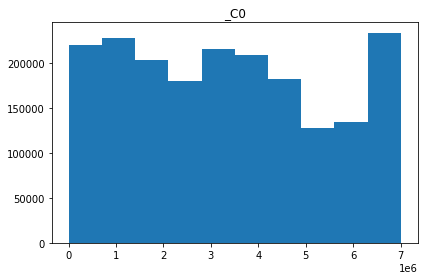

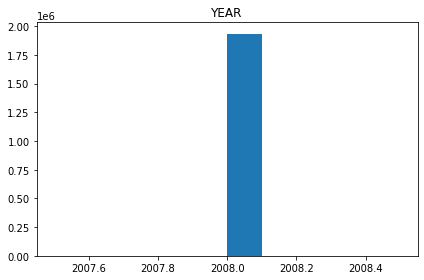

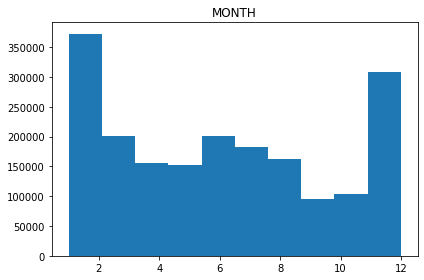

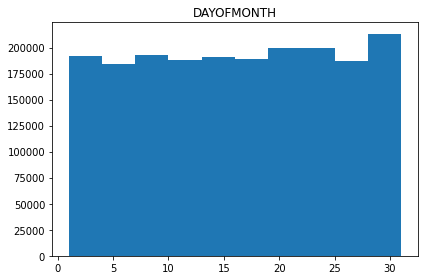

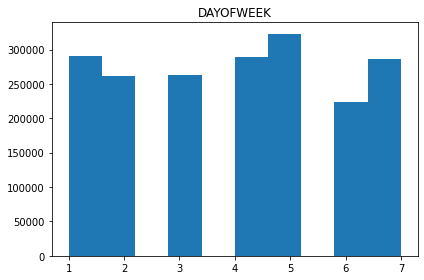

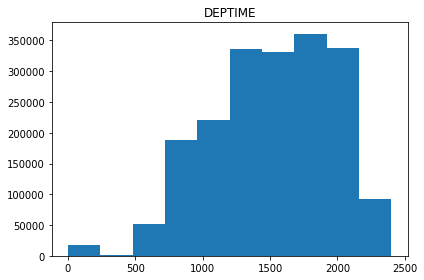

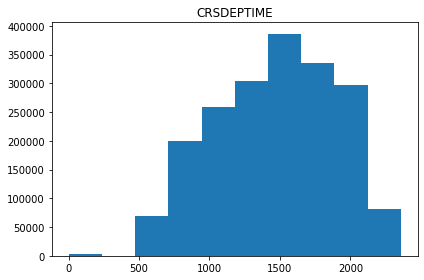

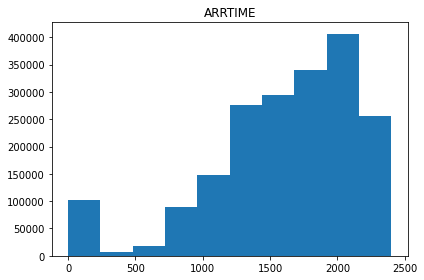

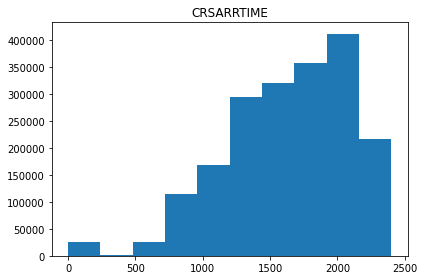

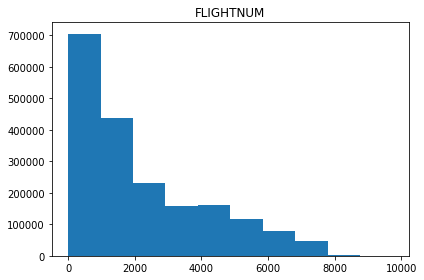

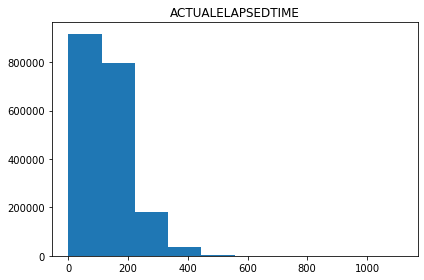

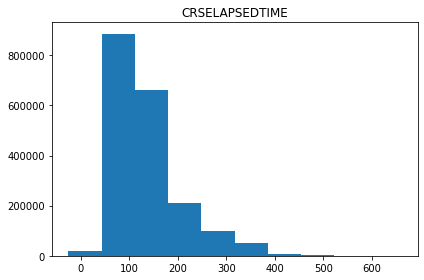

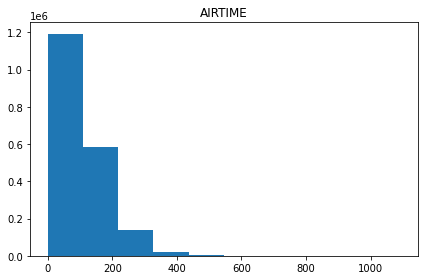

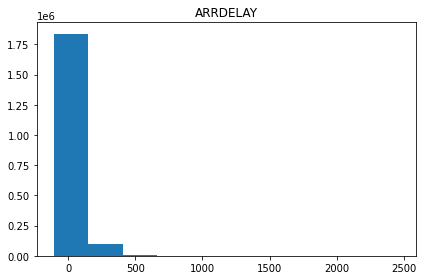

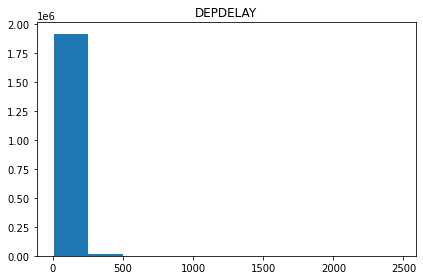

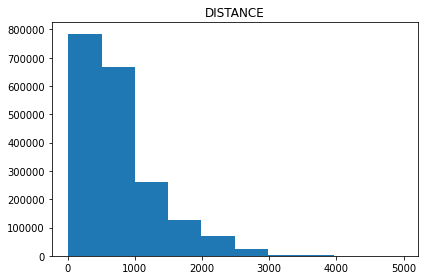

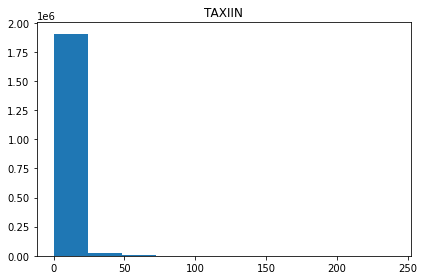

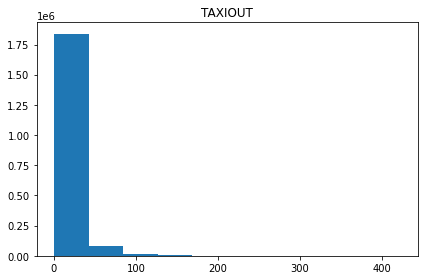

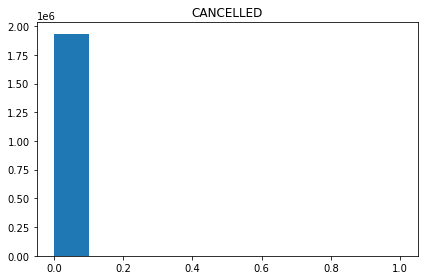

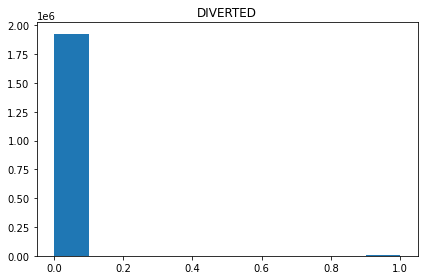

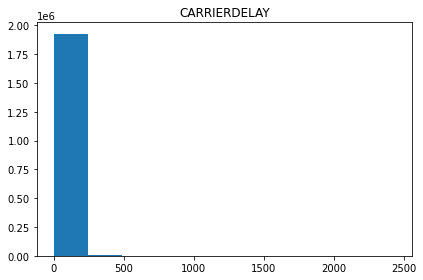

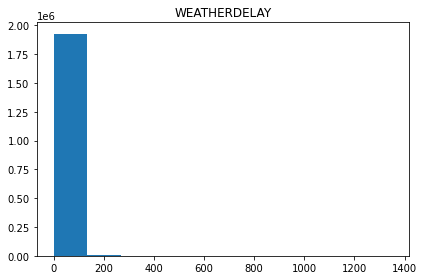

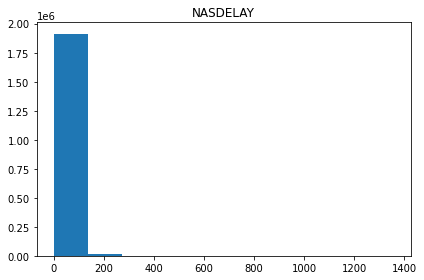

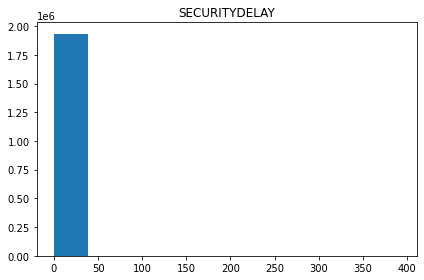

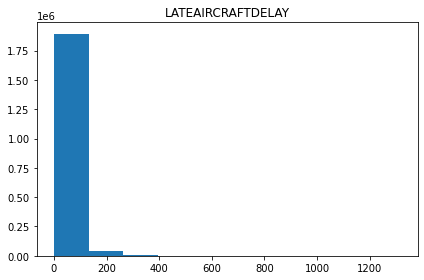

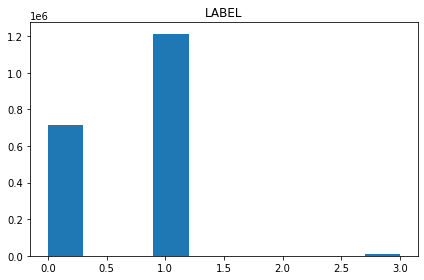

In [134]:
for col,num in zip(df_pandas.describe().columns, range(1, len(df_pandas.columns))):
    plt.hist(df_pandas[col])
    plt.grid(False)
    plt.title(col.upper())
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='Month', ylabel='Number of Cancelled flights'>

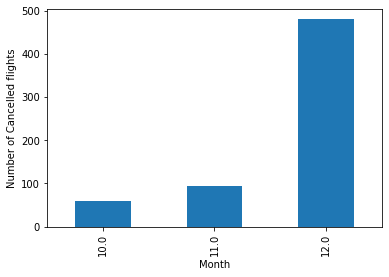

In [135]:
df_pandas[["Cancelled","Month"]].where(df_pandas["Cancelled"]==1).groupby("Month").count().plot(kind='bar',legend=False, ylabel="Number of Cancelled flights")

<AxesSubplot:xlabel='Month', ylabel='Number of Diverted flights'>

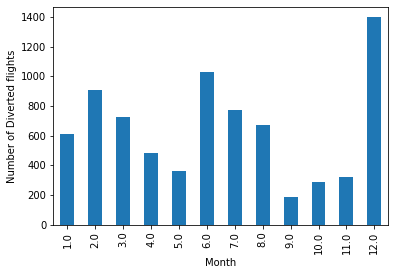

In [136]:
df_pandas[["Diverted","Month"]].where(df_pandas["Diverted"]==1).groupby("Month").count().plot(kind='bar',legend=False, ylabel="Number of Diverted flights")

<AxesSubplot:xlabel='Month', ylabel='Number of highly delayed flights'>

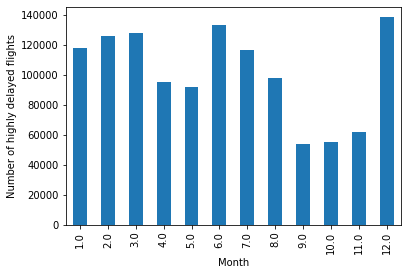

In [137]:
df_pandas[["label","Month"]].where(df_pandas["label"]==1).groupby("Month").count().plot(kind='bar',legend=False, ylabel="Number of highly delayed flights")

<AxesSubplot:xlabel='0 -Not cancelled 1-Cancelled', ylabel='Frequency'>

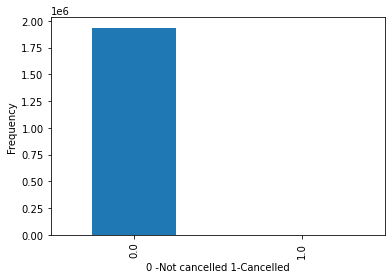

In [138]:
df_pandas["Cancelled"].value_counts().plot(kind="bar", xlabel="0 -Not cancelled 1-Cancelled", ylabel="Frequency")

<AxesSubplot:xlabel='CancellationCode', ylabel='Frequency'>

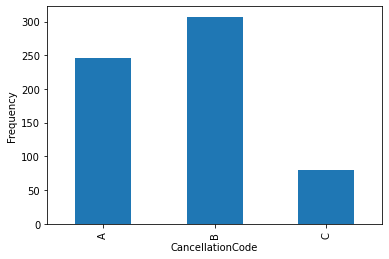

In [139]:
df_pandas[["CancellationCode", "Cancelled"]].where(df_pandas["Cancelled"]==1).groupby("CancellationCode").count().plot(kind="bar", legend=False, ylabel="Frequency")

<AxesSubplot:xlabel='0 -Not diverted 1-diverted', ylabel='Frequency'>

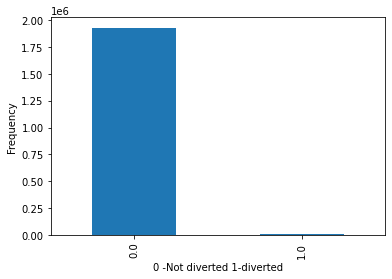

In [140]:
df_pandas["Diverted"].value_counts().plot(kind="bar", xlabel="0 -Not diverted 1-diverted", ylabel="Frequency")

<AxesSubplot:xlabel='0-Slightly delayed 1-highly delayed 2-cancelled 3-diverted', ylabel='Frequency'>

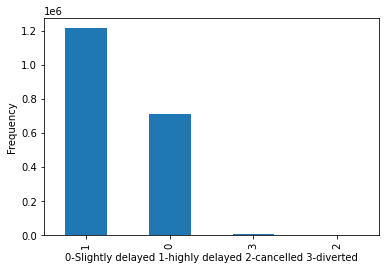

In [141]:
df_pandas["label"].value_counts().plot(kind="bar", xlabel="0-Slightly delayed 1-highly delayed 2-cancelled 3-diverted", ylabel="Frequency")

<AxesSubplot:xlabel='UniqueCarrier', ylabel='Number of highly delyaed flights'>

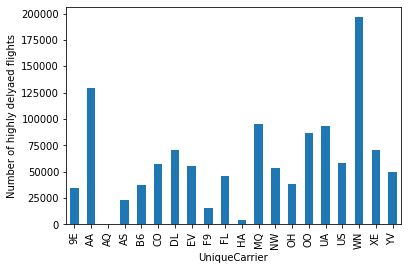

In [142]:
df_pandas[["label","UniqueCarrier"]].where(df_pandas["label"]==1).groupby("UniqueCarrier").count().plot(kind='bar', legend=False, ylabel='Number of highly delyaed flights')

<AxesSubplot:xlabel='UniqueCarrier', ylabel='Number of Cancelled flights'>

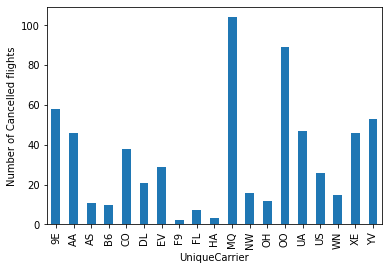

In [143]:
df_pandas[["label","UniqueCarrier"]].where(df_pandas["label"]==2).groupby("UniqueCarrier").count().plot(kind='bar', legend=False, ylabel='Number of Cancelled flights')

<AxesSubplot:xlabel='UniqueCarrier', ylabel='Number of diverted flights'>

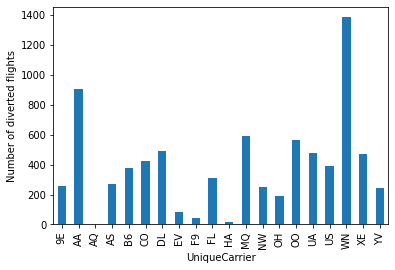

In [144]:
df_pandas[["label","UniqueCarrier"]].where(df_pandas["label"]==3).groupby("UniqueCarrier").count().plot(kind='bar', legend=False, ylabel='Number of diverted flights')

<AxesSubplot:xlabel='UniqueCarrier', ylabel='Average delay in highly delayed flights'>

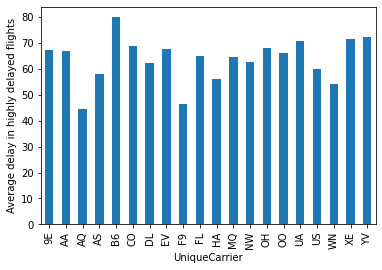

In [145]:
df_pandas[["ArrDelay","UniqueCarrier"]].where(df_pandas["label"]==1).groupby("UniqueCarrier").mean().plot(kind='bar', legend=False, ylabel='Average delay in highly delayed flights')

<AxesSubplot:xlabel='Origin', ylabel='Average delay'>

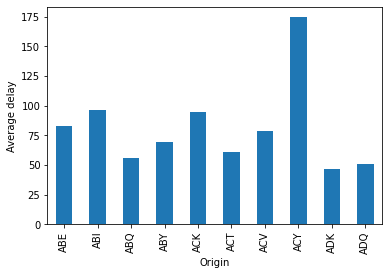

In [146]:
df_pandas[["ArrDelay","Origin"]].where(df_pandas["label"]==1).groupby("Origin").mean()[:10].plot(kind='bar', legend=False, ylabel='Average delay')

<AxesSubplot:xlabel='Dest', ylabel='Average delay'>

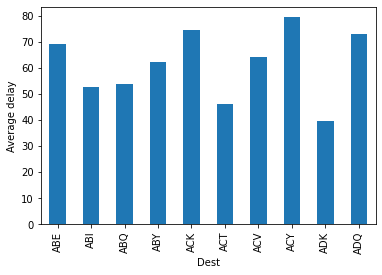

In [147]:
df_pandas[["ArrDelay","Dest"]].where(df_pandas["label"]==1).groupby("Dest").mean()[:10].plot(kind='bar', legend=False, ylabel='Average delay')

<AxesSubplot:xlabel='DayOfWeek', ylabel='Number of flights diverted'>

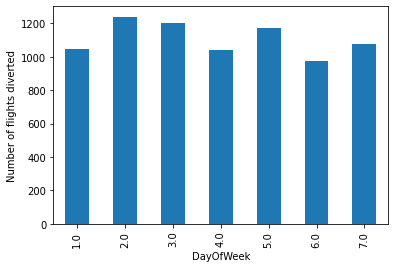

In [148]:
df_pandas[["DayOfWeek","Diverted"]].where(df_pandas["Diverted"]==1).groupby("DayOfWeek").count().plot(kind='bar', legend=False, ylabel='Number of flights diverted')

<AxesSubplot:xlabel='DayOfWeek', ylabel='Number of flights cancelled'>

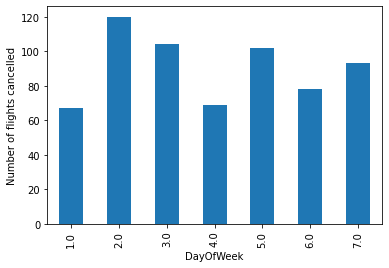

In [149]:
df_pandas[["DayOfWeek","Cancelled"]].where(df_pandas["Cancelled"]==1).groupby("DayOfWeek").count().plot(kind='bar', legend=False, ylabel='Number of flights cancelled')

<AxesSubplot:xlabel='DayOfWeek', ylabel='Number of highly delayed flights'>

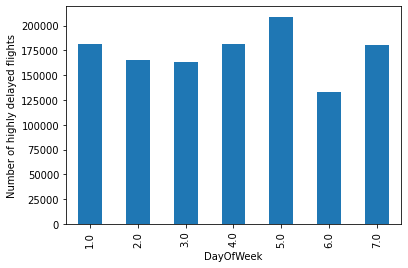

In [150]:
df_pandas[["DayOfWeek","label"]].where(df_pandas["label"]==1).groupby("DayOfWeek").count().plot(kind='bar', legend=False, ylabel='Number of highly delayed flights')

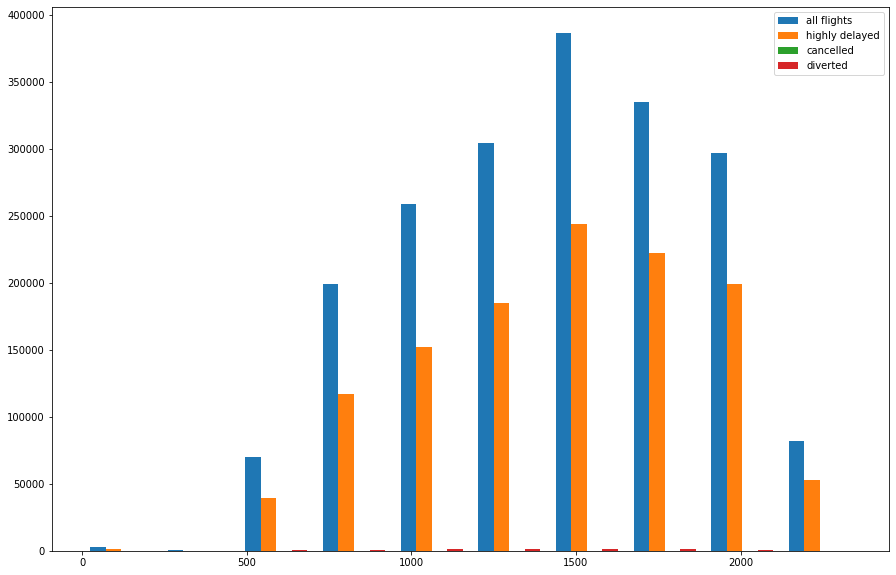

In [177]:
fig, ax = plt.subplots(figsize = (15,10))
ax.hist([df_pandas["CRSDepTime"], df_pandas["CRSDepTime"].where(df_pandas["label"]==1),df_pandas["CRSDepTime"].where(df_pandas["Cancelled"]==1), df_pandas["CRSDepTime"].where(df_pandas["Diverted"]==1)], bins = 10, label = ["all flights","highly delayed", "cancelled", "diverted"])
plt.legend()

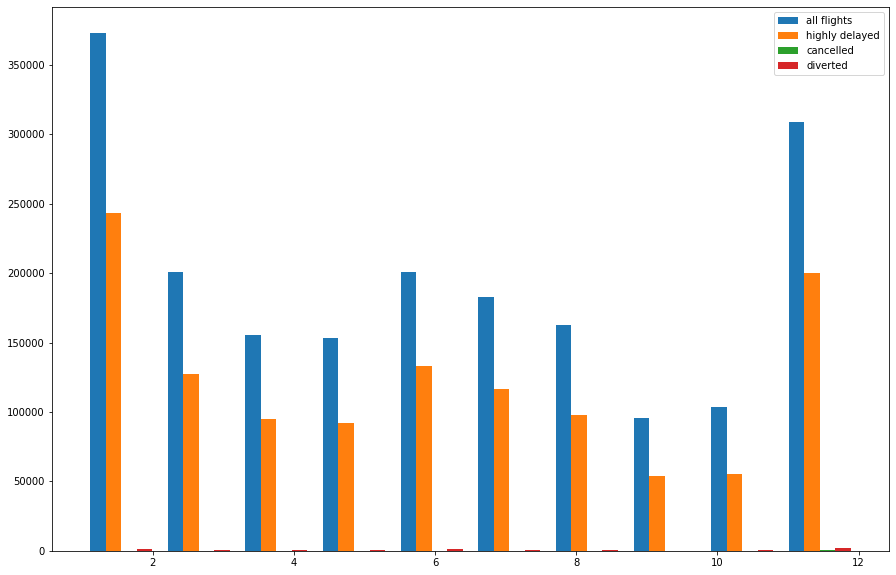

In [178]:
fig, ax = plt.subplots(figsize = (15,10))
ax.hist([df_pandas["Month"], df_pandas["Month"].where(df_pandas["label"]==1),df_pandas["Month"].where(df_pandas["Cancelled"]==1), df_pandas["Month"].where(df_pandas["Diverted"]==1)], bins = 10, label = ["all flights","highly delayed", "cancelled", "diverted"])
plt.legend()

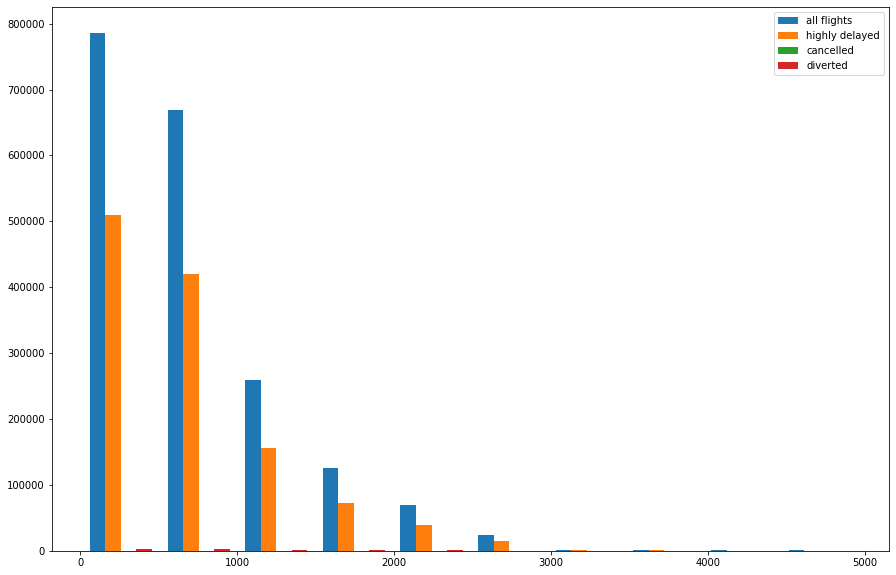

In [179]:
fig, ax = plt.subplots(figsize = (15,10))
ax.hist([df_pandas["Distance"], df_pandas["Distance"].where(df_pandas["label"]==1),df_pandas["Distance"].where(df_pandas["Cancelled"]==1), df_pandas["Distance"].where(df_pandas["Diverted"]==1)], bins = 10, label = ["all flights","highly delayed", "cancelled", "diverted"])
plt.legend()

In [180]:
df_pandas['total_delay'] = (df_pandas['CarrierDelay'] + df_pandas['WeatherDelay'] + df_pandas['NASDelay'] + df_pandas['SecurityDelay'] + df_pandas['LateAircraftDelay'])

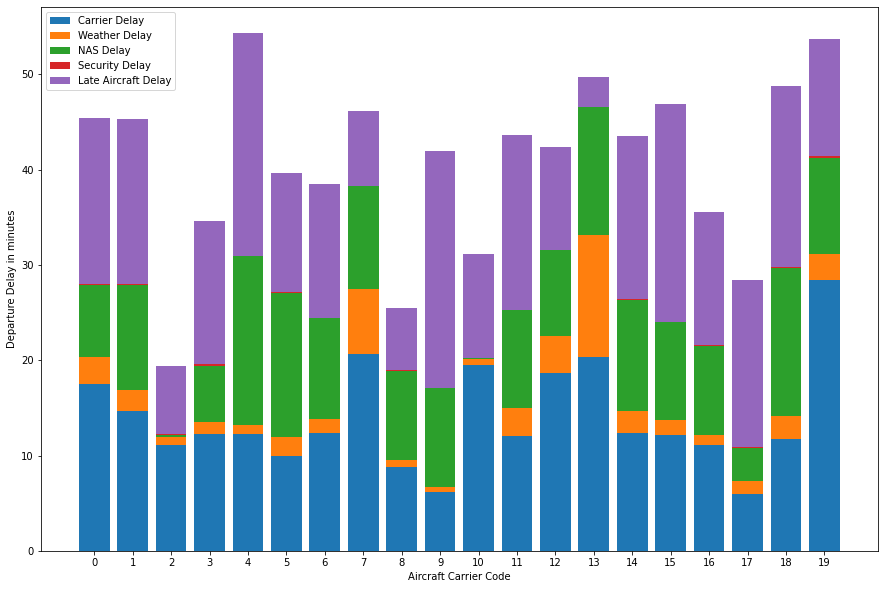

In [181]:
carrier_group = df_pandas['CarrierDelay'].groupby(df_pandas['UniqueCarrier']).mean()
weather_group = df_pandas['WeatherDelay'].groupby(df_pandas['UniqueCarrier']).mean()
nas_group = df_pandas['NASDelay'].groupby(df_pandas['UniqueCarrier']).mean()
security_group = df_pandas['SecurityDelay'].groupby(df_pandas['UniqueCarrier']).mean()
late_group = df_pandas['LateAircraftDelay'].groupby(df_pandas['UniqueCarrier']).mean()

w_bottom = carrier_group.values
n_bottom = w_bottom + weather_group.values
s_bottom = n_bottom + nas_group.values
l_bottom = s_bottom + security_group.values

x = carrier_group.index.values

fig, ax = plt.subplots(figsize = (15,10))

ax.set_xticks(np.arange(len(x)))
ax.bar(np.arange(len(x)),carrier_group.values, label='Carrier Delay')
ax.bar(np.arange(len(x)),weather_group.values, bottom=w_bottom, label='Weather Delay')
ax.bar(np.arange(len(x)),nas_group.values, bottom=n_bottom, label='NAS Delay')
ax.bar(np.arange(len(x)),security_group.values, bottom=s_bottom, label='Security Delay')
ax.bar(np.arange(len(x)),late_group.values, bottom=l_bottom, label='Late Aircraft Delay')

ax.set_xlabel('Aircraft Carrier Code')
ax.set_ylabel('Departure Delay in minutes')

plt.legend()
plt.show()

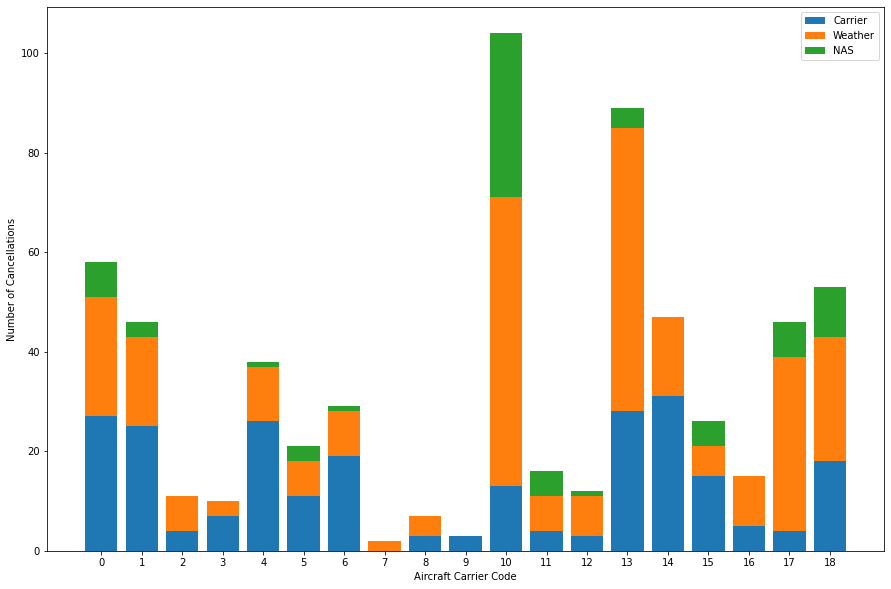

In [182]:
cancelled_group = df_pandas[df_pandas["Cancelled"]==1].groupby(['UniqueCarrier','CancellationCode']).size().reindex(fill_value=0.0).unstack()
cg = cancelled_group.fillna(0)

b_bottom = cg.loc[:,'A'].values
c_bottom = b_bottom + cg.loc[:,'B'].values
d_bottom = c_bottom + cg.loc[:,'B'].values

x = cg.loc[:,'A'].index.values

fig, ax = plt.subplots(figsize = (15,10))

ax.set_xticks(np.arange(len(x)))
ax.bar(np.arange(len(x)),cg.loc[:,'A'].values, align='center', label='Carrier')
ax.bar(np.arange(len(x)),cg.loc[:,'B'].values, align='center', bottom=b_bottom, label='Weather')
ax.bar(np.arange(len(x)),cg.loc[:,'C'].values, align='center', bottom=c_bottom, label='NAS')

ax.set_xlabel('Aircraft Carrier Code')
ax.set_ylabel('Number of Cancellations')

plt.legend()
plt.show()

In [104]:
import seaborn as sns
numeric_columns_for_heatmap = []
for col in df_pandas.columns:
    if df_pandas[col].dtype != "object":
        numeric_columns_for_heatmap.append(col)

<AxesSubplot:>

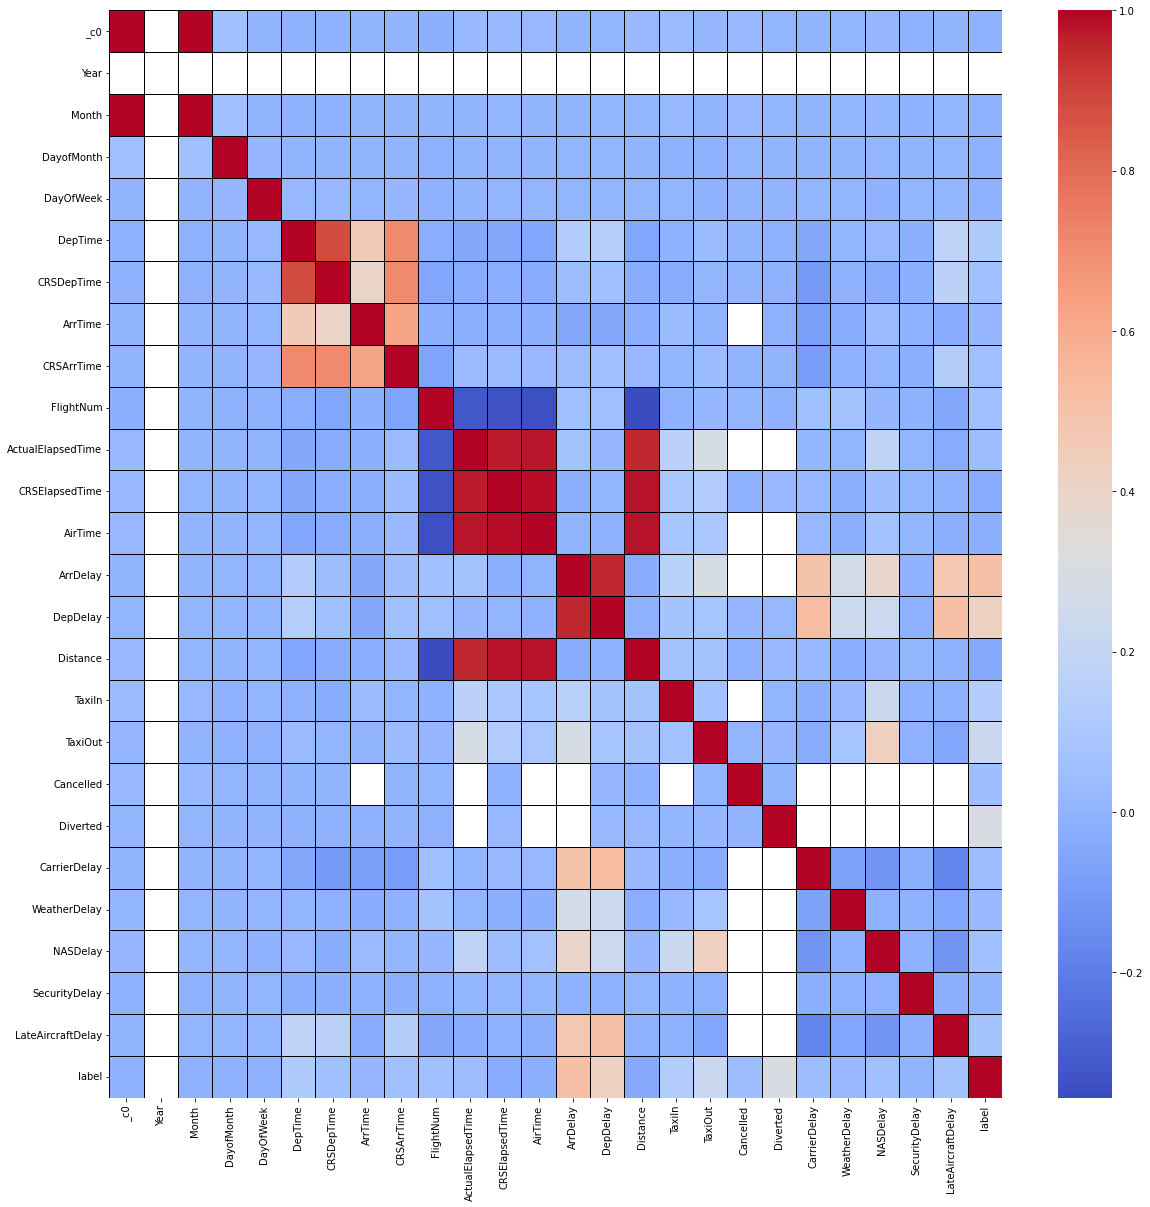

In [103]:
fig, ax = plt.subplots(figsize=(20,20))     
sns.heatmap(df_pandas[numeric_columns_for_heatmap].corr(), cmap = 'coolwarm', linewidths = 0.5, linecolor = 'black', ax=ax)

In [ ]:
#Scaling
#Removing unwanted columns 
#Splitting the dataset 
#Machine Learning algorithm